# The Iris Dataset
**Nguyen Dang Minh, PhD**

## Import libraries and set parameters

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
rcParams['axes.facecolor'] = '0.9'
rcParams['axes.grid'] = True
rcParams['grid.color'] = 'k'
rcParams['grid.linestyle'] = ':'
rcParams['grid.linewidth'] = 1.
rcParams['grid.alpha'] = 0.5
rcParams['font.size'] = 18
rcParams['figure.dpi'] = 150

In [3]:
#sns.set(style="dark")
plt.style.use('seaborn')

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Data visualization

In [5]:
iris = load_iris()
df = pd.DataFrame(data=iris['data'],columns=iris['feature_names'])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Species distribution

Text(0.5, 1.0, 'Species distribution')

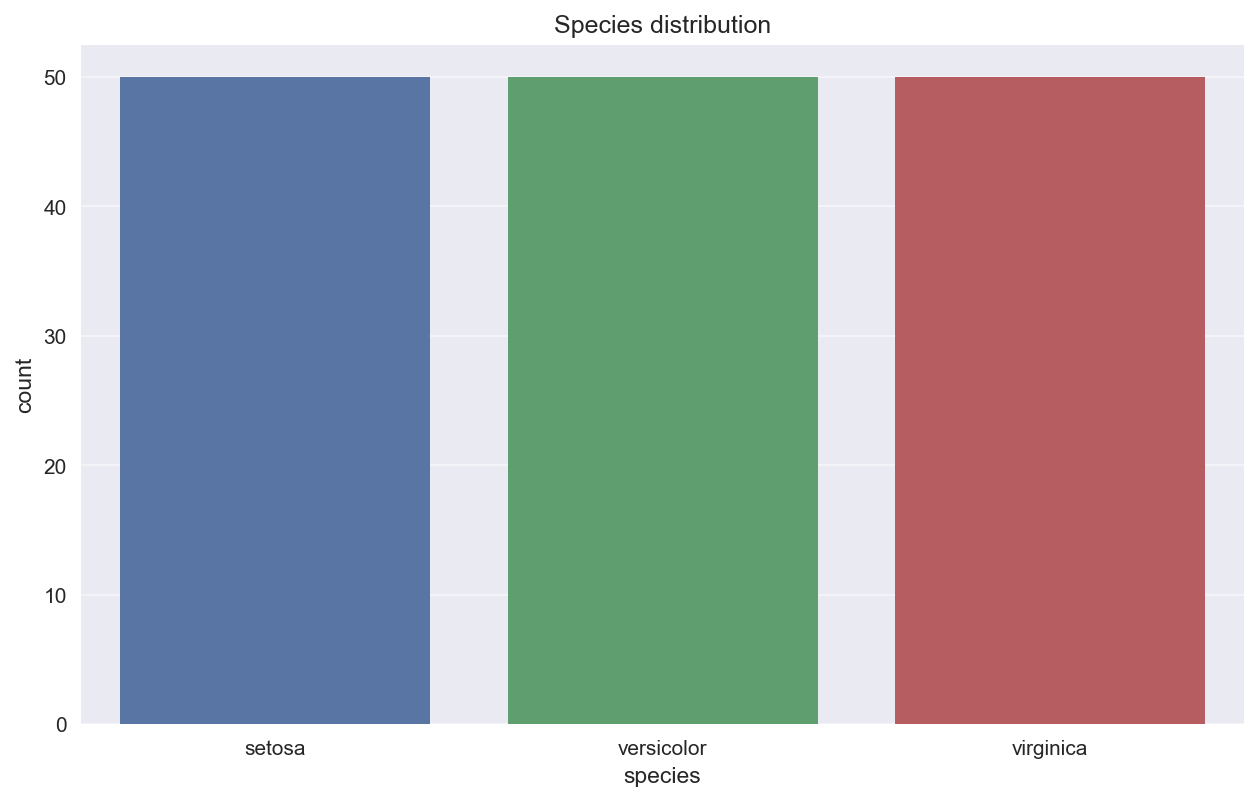

In [6]:
fig = plt.figure(figsize=(10,6))
sns.countplot(x='species', data=df)
plt.title('Species distribution')

### Species by features

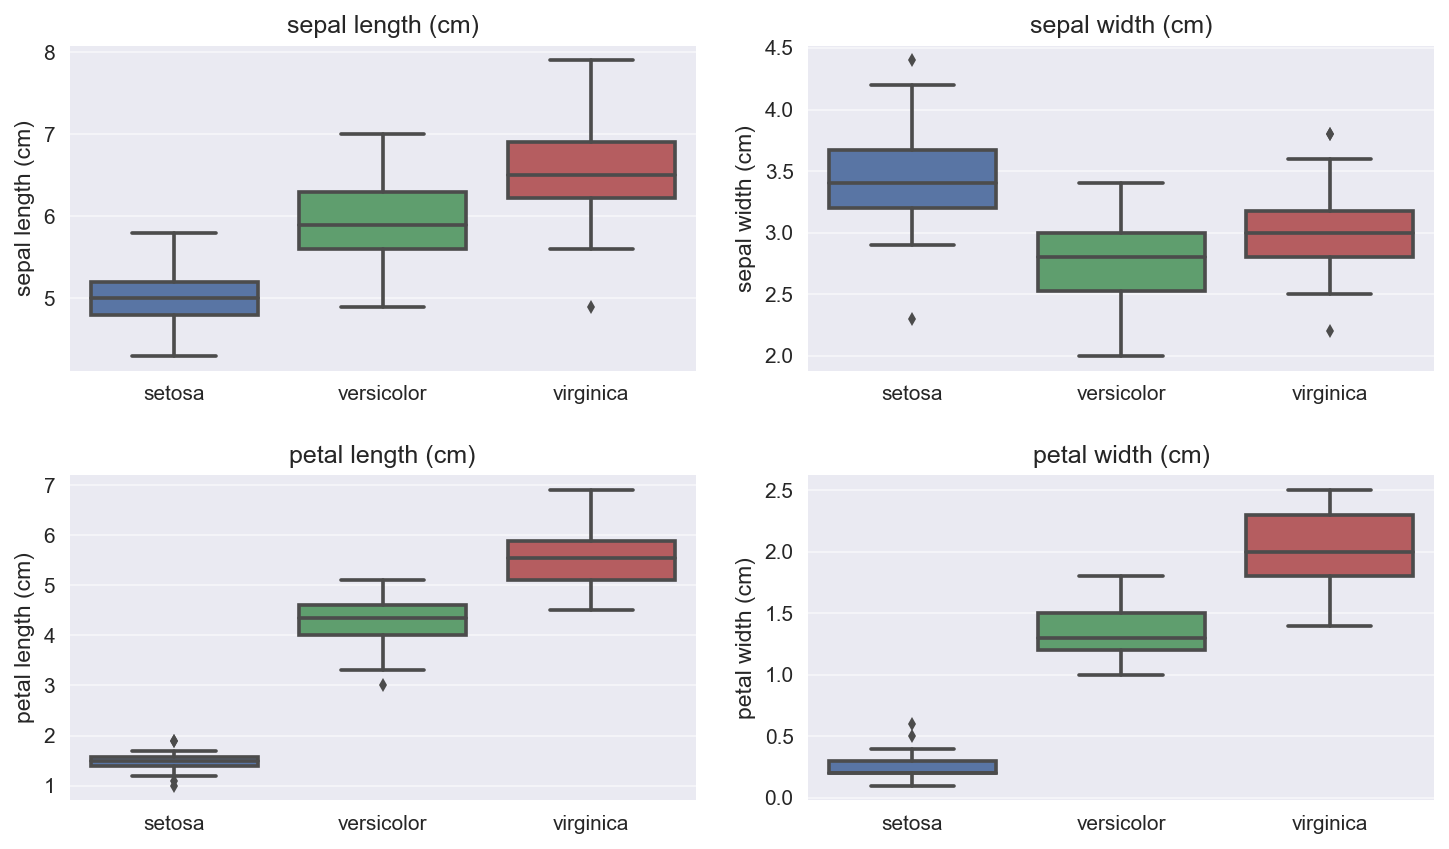

In [7]:
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

fig = plt.figure(figsize=(10,6))
for i in range(len(features)):
    ax = fig.add_subplot(2,2,i+1)
    sns.boxplot(x='species', y=features[i], data=df, ax=ax)
    ax.set_title(features[i])
    ax.set_xlabel('')
    
plt.tight_layout()

Text(0.5, 1.02, 'Overall data distribution')

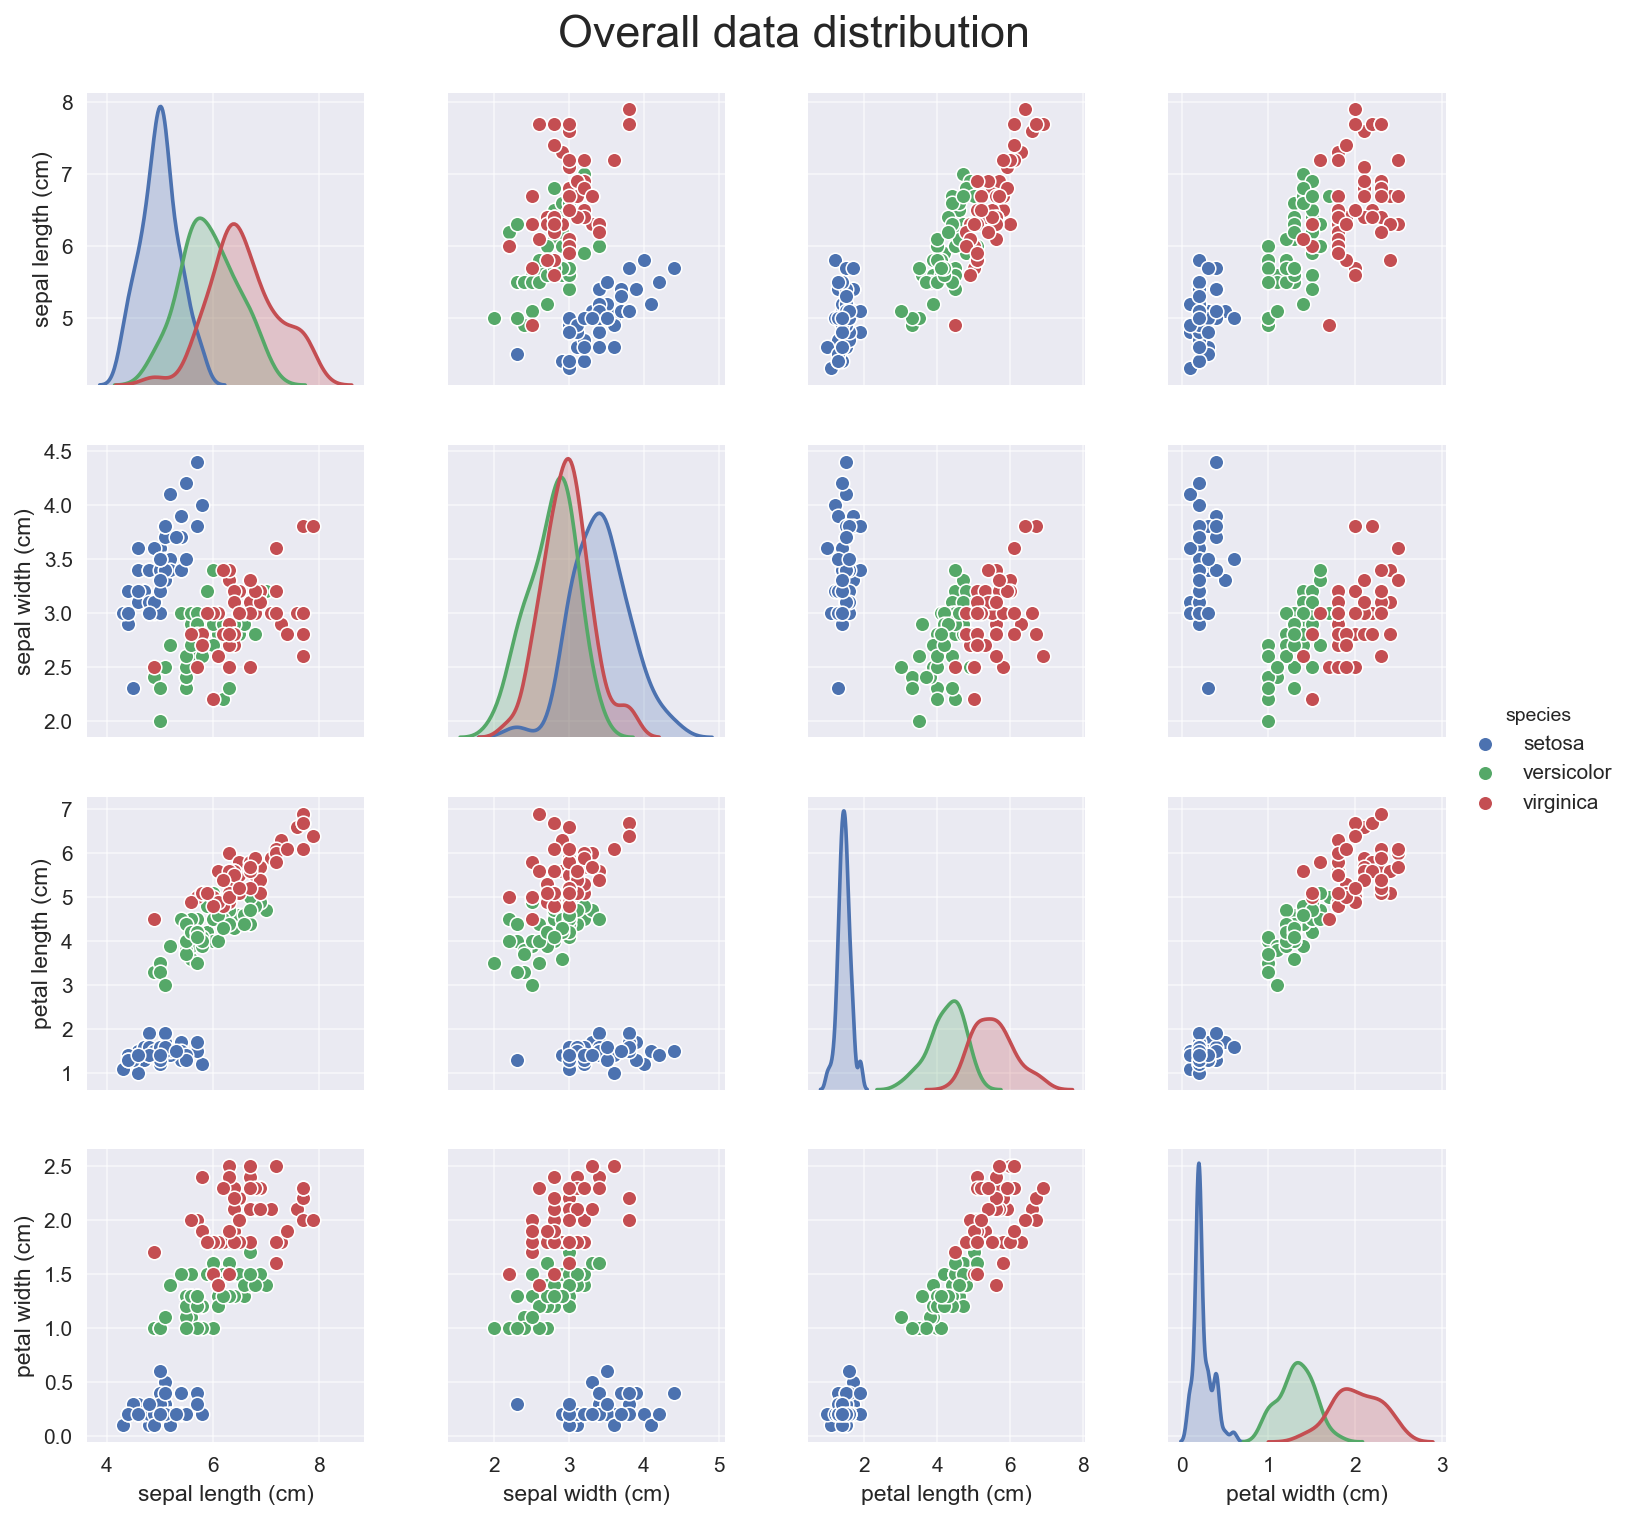

In [8]:
g = sns.pairplot(data=df,kind='scatter', hue='species')
g.fig.suptitle('Overall data distribution', y=1.02)

## Pricipal Components Analysis (PCA)

In [9]:
# Feature scaling
scaler = StandardScaler()
df_pca = df.copy()
df_pca[features] = scaler.fit_transform(df[features])

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_pca[features])
df_pca['principal component 1'] = principal_components[:,0]
df_pca['principal component 2'] = principal_components[:,1]

In [10]:
df_pca.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,principal component 1,principal component 2
0,-0.900681,1.019004,-1.340227,-1.315444,setosa,-2.264703,0.480027
1,-1.143017,-0.131979,-1.340227,-1.315444,setosa,-2.080961,-0.674134
2,-1.385353,0.328414,-1.397064,-1.315444,setosa,-2.364229,-0.341908
3,-1.506521,0.098217,-1.283389,-1.315444,setosa,-2.299384,-0.597395
4,-1.021849,1.249201,-1.340227,-1.315444,setosa,-2.389842,0.646835


In [11]:
print("Explained variance: %.3f%%" %(pca.explained_variance_ratio_.sum()*100))

Explained variance: 95.813%


Text(0.5, 1.0, 'Pair-wise correlation')

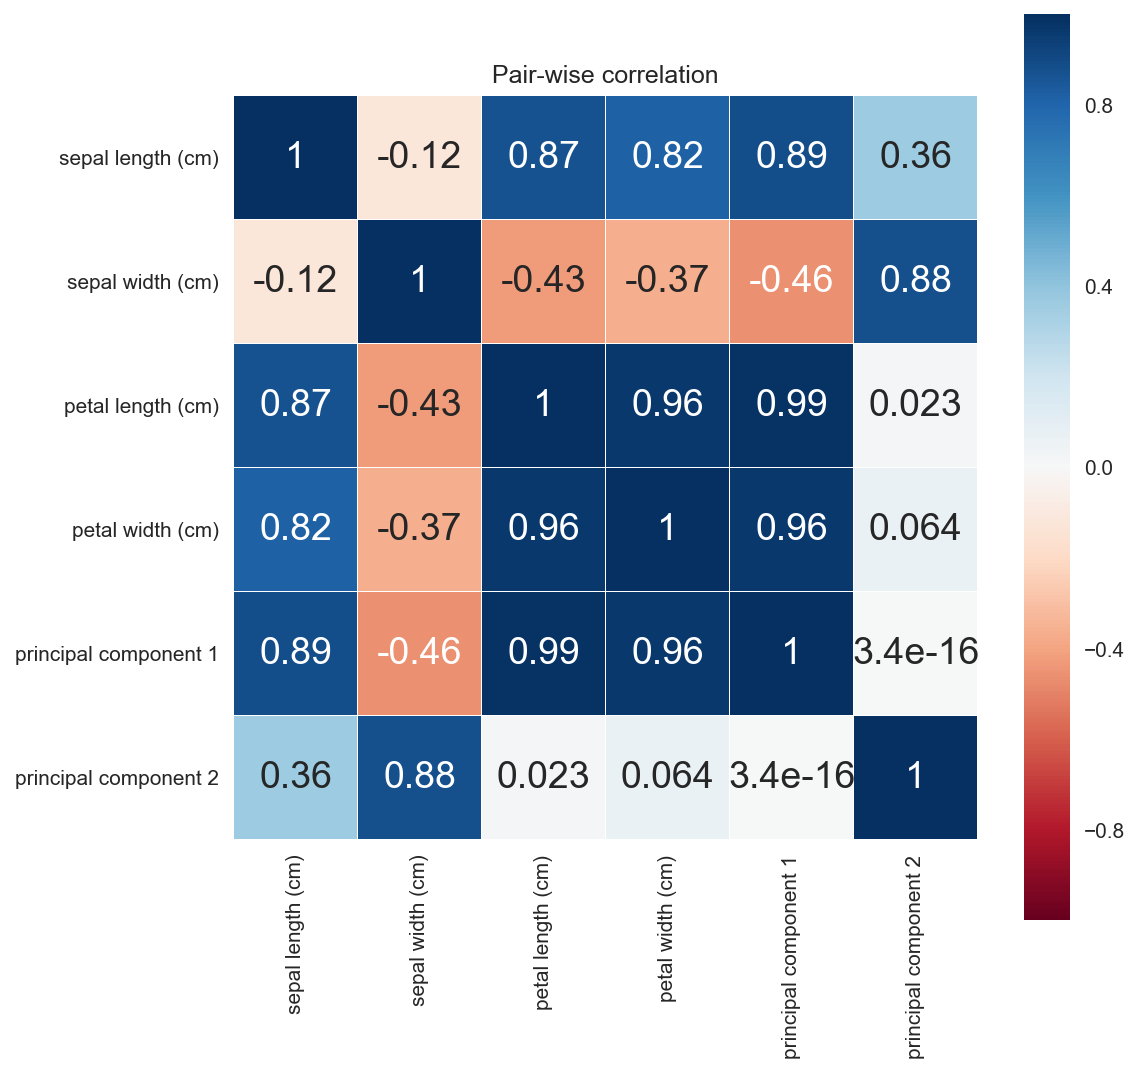

In [12]:
# Plotting correlation
corr_features = features + ['principal component 1', 'principal component 2']
colormap = plt.cm.RdBu
fig = plt.figure(figsize=(8,8))
sns.heatmap(df_pca[corr_features].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')

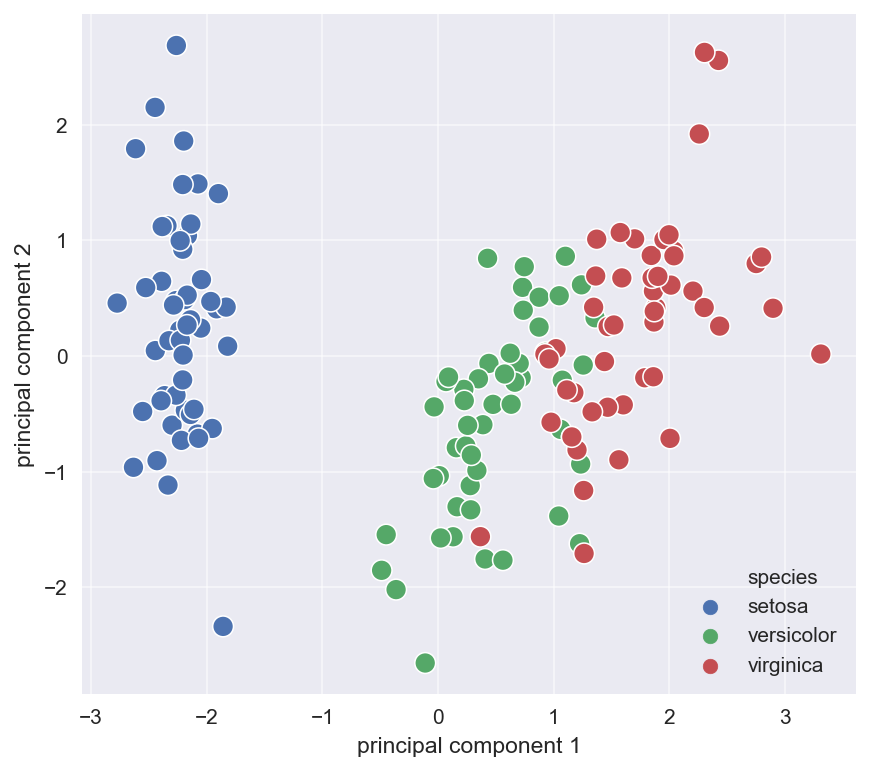

In [13]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='species', data=df_pca, s=100)
plt.gca().set_aspect('equal', adjustable='box')


## Building model
### Preparing data and models

In [20]:
X_orig = df_pca[features]
X = df_pca[['principal component 1', 'principal component 2']]
Y = df_pca['species'].map({'setosa':0, 'versicolor':1, 'virginica':2})

In [42]:
clf_naive = GaussianNB()
clf_svm = SVC()
clf_tree = DecisionTreeClassifier()
clf_knn = KNeighborsClassifier()
clf_rf = RandomForestClassifier()
clf_log = LogisticRegression()

models = [clf_svm, clf_knn, clf_tree, clf_rf, clf_naive, clf_log]
names = ['SVM', 'KNN', 'Decision tree', 'Random forest', 'Naive Bayes', 'Logistic regression']
model_summary = pd.DataFrame()
model_summary['Model name'] = names

acc_score_list = []
f1_score_list = []

### Training

In [43]:
for i in range(len(models)):
    name = names[i]
    model = models[i]
    folds = StratifiedKFold(n_splits=5, random_state=1)
    acc_score_now = 0
    f1_score_now = 0
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_orig.values, Y.values)):
        X_train = X_orig.iloc[trn_idx]
        Y_train = Y.iloc[trn_idx]
        X_val = X_orig.iloc[val_idx]
        Y_val = Y.iloc[val_idx]
        
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_val)
        acc_score_now += accuracy_score(Y_val, Y_pred)/5.
        f1_score_now += f1_score(Y_val, Y_pred, average='macro')/5.
        
    acc_score_list.append(acc_score_now)
    f1_score_list.append(f1_score_now)
   

In [44]:
model_summary['accuracy_score'] = acc_score_list
model_summary['f1_score'] = f1_score_list
model_summary = model_summary.sort_values(by='accuracy_score', ascending=False)
model_summary.head(10)

,Model name,accuracy_score,f1_score
0,SVM,0.966667,0.966617
2,Decision tree,0.966667,0.966583
1,KNN,0.960000,0.959832
3,Random forest,0.953333,0.952840
4,Naive Bayes,0.953333,0.953047
5,Logistic regression,0.906667,0.905681


### Prediction boundary

In [45]:
cmap = colors.ListedColormap(['blue','green', 'red'])
def points_plot(ax, X, clf, mesh=True, colorscale=cmap, alpha=0.1, psize=10):
    x_min, x_max = -3.8, 3.8
    y_min, y_max = -3., 3.
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    #plt.figure(figsize=(10,6))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape).astype(int)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=colorscale, alpha=alpha, axes=ax)
    #ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="black")
    # and testing points
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.gca().set_aspect('equal', adjustable='box')
    return ax

Text(0.5, 1.03, 'Prediction boundaries')

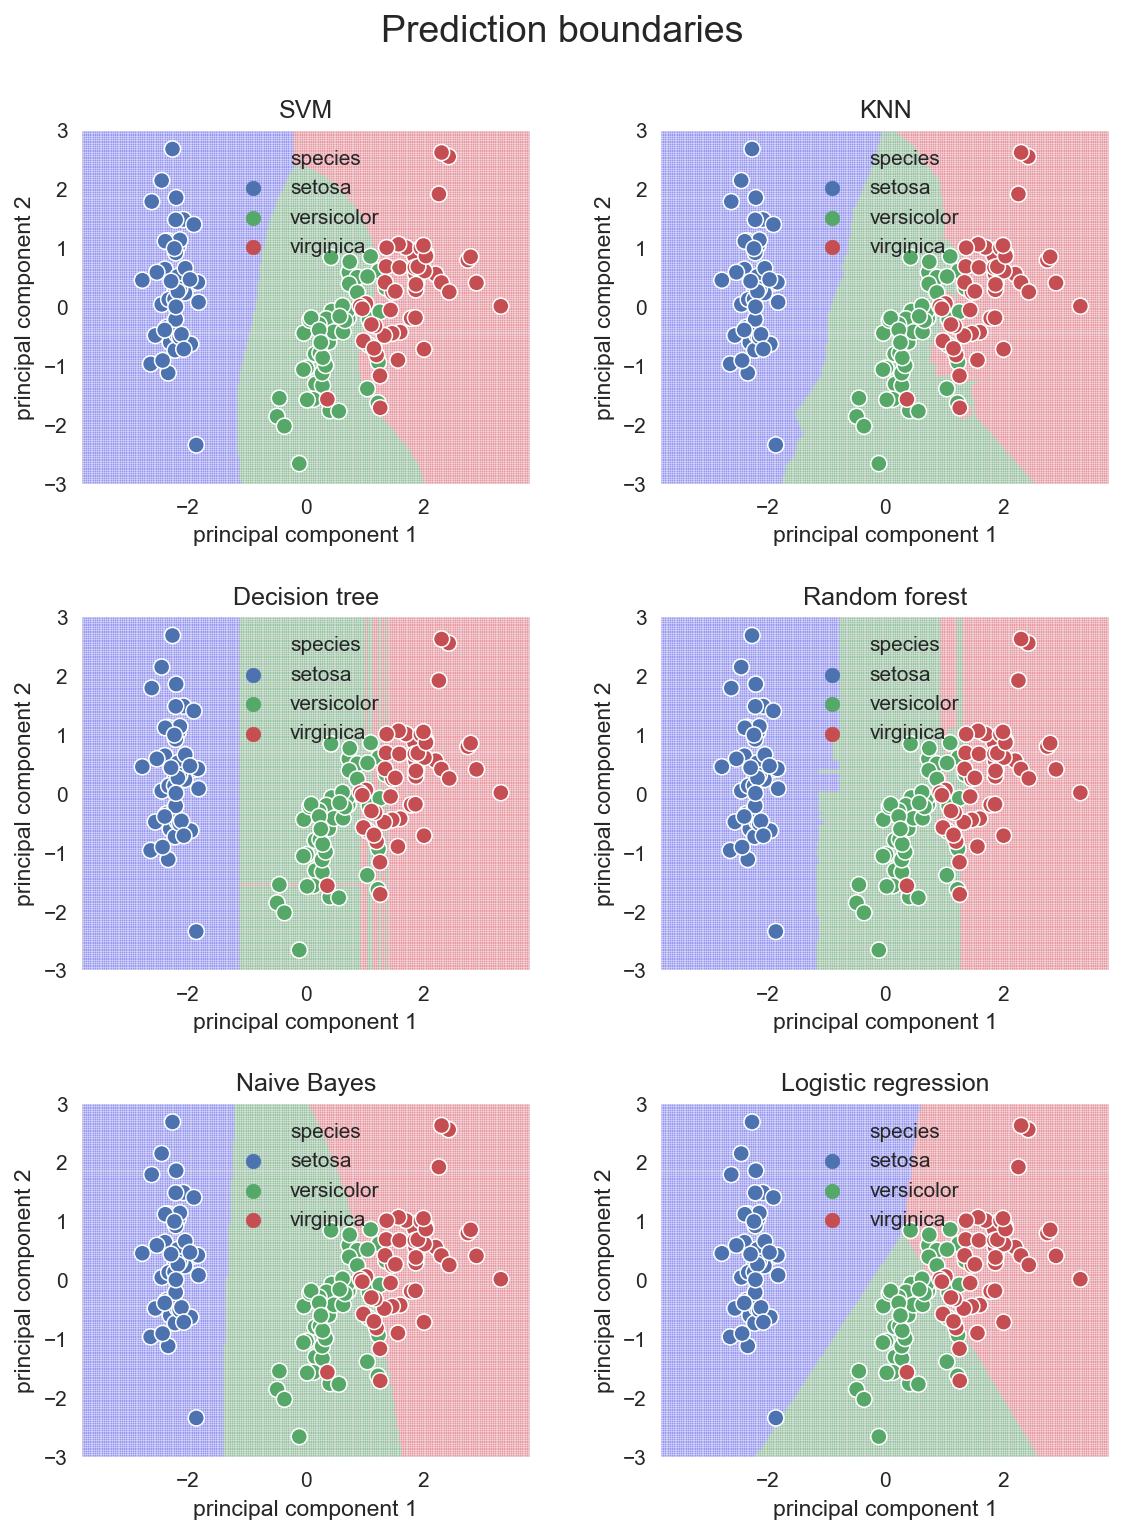

In [48]:
fig = plt.figure(figsize=(8,10), dpi=150)
for i in range(len(names)):
    model = models[i]
    model.fit(X,Y)
    ax = fig.add_subplot(3,2,i+1)
    ax = points_plot(ax, X.values, model)
    sns.scatterplot(x='principal component 1', y='principal component 2', hue='species', data=df_pca, s=60, ax=ax)
    ax.set_title(names[i])

plt.tight_layout()
fig.suptitle('Prediction boundaries', fontsize=18, y=1.03)